# Testing UniRef Model

In [1]:
import torch
from transformers import T5EncoderModel, T5Tokenizer
import re
import numpy as np

# Load model
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False)
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")

# Load into GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#model = model.to(device)
#model = model.eval() 

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.20.layer.1.EncDecAttention.k.weight', 'decoder.block.21.layer.0.layer_norm.weight', 'decoder.block.4.layer.2.DenseReluDense.wi.weight', 'decoder.block.11.layer.1.EncDecAttention.o.weight', 'decoder.block.19.layer.0.SelfAttention.v.weight', 'decoder.block.3.layer.1.EncDecAttention.k.weight', 'decoder.block.13.layer.2.DenseReluDense.wo.weight', 'decoder.embed_tokens.weight', 'decoder.block.6.layer.2.DenseReluDense.wo.weight', 'decoder.block.9.layer.1.EncDecAttention.o.weight', 'decoder.block.4.layer.2.layer_norm.weight', 'decoder.block.0.layer.2.DenseReluDense.wo.weight', 'decoder.block.21.layer.1.EncDecAttention.o.weight', 'decoder.block.23.layer.1.EncDecAttention.q.weight', 'decoder.block.5.layer.1.EncDecAttention.k.weight', 'decoder.block.18.layer.2.DenseReluDense.wo.weight', 'decoder.block.17.layer.2.DenseReluDense.wi.weight', 'decoder.block.14.layer.2.D

In [2]:
# Tokenize, encode, and load example sequences
ex_seq = ["A T W","A T E"]
ex_seq = [re.sub(r"[UZOB]", "X", sequence) for sequence in ex_seq]
ids = tokenizer.batch_encode_plus(ex_seq, add_special_tokens=True, padding=True)
input_ids = torch.tensor(ids['input_ids']).to(device)
attention_mask = torch.tensor(ids['attention_mask']).to(device)

# Extract sequence features
with torch.no_grad():
    embedding = model(input_ids=input_ids,attention_mask=attention_mask)
embedding = embedding.last_hidden_state.cpu().numpy()

# Remove padding and special tokens
features = [] 
for seq_num in range(len(embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = embedding[seq_num][:seq_len-1]
    features.append(seq_emd)
len(features)

2

# Encoding Real Protein Sequences

In [3]:
from Bio import SeqIO

# Use biopython to parse fasta file and append sequences to list
sequences = []
with open("sequence.fasta") as file:
    for seq in SeqIO.parse(file, 'fasta'):

        # Add space after each character so each amino acid is vectorized
        seq = str(seq.seq)
        seq = ' '.join([*seq])
        sequences.append(seq)

# Use two sequences for testing
seq1 = sequences[4]
seq2 = sequences[6]
sequences = [seq1, seq2]

In [4]:
# Tokenize, encode, pad
ids = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding=True)
input_ids = torch.tensor(ids['input_ids']).to(device)
attention_mask = torch.tensor(ids['attention_mask']).to(device)

# Extract sequence features
with torch.no_grad():
    embedding = model(input_ids=input_ids,attention_mask=attention_mask)  #decoder_input_ids for decoder weights
embedding = embedding.last_hidden_state.cpu().numpy()

# Remove padding and special tokens
features = [] 
for seq_num in range(len(embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = embedding[seq_num][:seq_len-1]
    features.append(seq_emd)
len(features)

2

Number of vectors is half the length of a sequence with individual amino acids due to the space characters delineating each residue.

# Finding Significant Cosine Similarity Between Embedded Amino Acids

In [40]:
"""================================================================================================
This script takes two protein sequences of varying length and finds the highest scoring global
alignment between the two.

Ben Iovino  01/25/23   VecAligns
================================================================================================"""

import argparse
import numpy as np
from Bio import SeqIO


def parse_fasta(filename):
    """=============================================================================================
    This function accepts a fasta file name and returns the sequence.

    :param filename: name of file
    return: sequence
    ============================================================================================="""

    # Parse fasta file
    seq = ''
    with open(filename, 'r', encoding='utf8') as file:
        for seq in SeqIO.parse(file, 'fasta'):
            seq = str(seq.seq)
    return seq


def global_align(seq1, seq2, subs_matrix, gopen, gext):
    """=============================================================================================
    This function accepts two sequences, creates a matrix corresponding to their lengths, and
    calculates the score of the alignments for each index. A second matrix is scored so that the
    best alignment can be tracebacked.

    :param seq1: first sequence
    :param seq2: second sequence
    :param subs_matrix: substitution scoring matrix (i.e. BLOSUM62)
    :param gopen: gap penalty for opening a new gap
    :param gext: gap penalty for extending a gap
    return: traceback matrix
    ============================================================================================="""

    # Protein alphabet
    chars = 'ACDEFGHIKLMNPQRSTVWY'

    # Initialize scoring and traceback matrix based on sequence lengths
    row_length = len(seq1)+1
    col_length = len(seq2)+1
    score_m = np.full((row_length, col_length), 0)
    trace_m = np.full((row_length, col_length), 0)

    # Initialize first row and column with gap values for S matrix, traceback values for T matrix
    for i in range(1, len(score_m[0])):
        score_m[0][i] = gopen+gext*i+1  # +1 to offset i starting at 1
        trace_m[0][i] = -1
    for i in range(1, len(score_m.T[0])):
        score_m.T[0][i] = gopen+gext*i+1
        trace_m.T[0][i] = 1

    scores = []

    # Score matrix by moving through each index
    gap = False
    for i, char in enumerate(seq1):
        seq1_char = char  # Character in 1st sequence
        seq1_index = chars.index(seq1_char)  # Corresponding row in BLOSUM matrix
        for j, char in enumerate(seq2):
            seq2_char = char

            # Preceding scoring matrix values
            diagonal = score_m[i][j]
            horizontal = score_m[i+1][j]
            vertical = score_m[i][j+1]

            # Score residues based off BLOSUM matrix
            # print(f'Char1: {seq1_char}, Char2: {seq2_char}, BLOSUM score: {score}')
            seq2_index = chars.index(seq2_char)  # Corresponding column in BLOSUM matrix
            matrix_score = subs_matrix[seq2_index][seq1_index]

            # Add to matrix values via scoring method
            diagonal += matrix_score
            if gap is False:  # Apply gap_open penalty if there is no gap
                horizontal += gopen
                vertical += gopen
            if gap is True:  # Apply gap_extension penalty if there is a gap
                horizontal += gext
                vertical += gext

            # Update gap status
            score = max(diagonal, horizontal, vertical)
            if score == horizontal:
                gap = True
            if score == vertical:
                gap = True
            if score == diagonal:
                gap = False

            # Assign value to traceback matrix
            if score == diagonal:
                scores.append(score)
                trace_m[i+1][j+1] = 0
            if score == horizontal:
                trace_m[i+1][j+1] = -1
            if score == vertical:
                trace_m[i+1][j+1] = 1

            # Assign value to scoring matrix
            score_m[i+1][j+1] = score

    return trace_m, scores


def write_align(seq1, seq2):
    """=============================================================================================
    This function accepts two sequences after gaps have been introduced and writes them to a file
    in no particular format (yet).

    :param seq1: first aligned sequence
    :param seq2: second aligned sequence
    ============================================================================================="""

    # Add space every 10 characters
    seq1 = [seq1[i:i+10] for i in range(0, len(seq1), 10)]
    seq1 = ' '.join(seq1)
    seq2 = [seq2[i:i+10] for i in range(0, len(seq2), 10)]
    seq2 = ' '.join(seq2)

    # Split sequences every 50 characters
    seq1_split = [seq1[i:i+55] for i in range(0, len(seq1), 55)]
    seq2_split = [seq2[i:i+55] for i in range(0, len(seq2), 55)]

    # Find max length sequence and write to file based on its length
    name1 = 'seque1'
    name2 = 'seque2'
    with open('global_alignment.txt', 'w', encoding='utf8') as file:
        file.write('PileUp\n\n\n')
        file.write(f'   MSF:  {len(seq1)}  Type:  P\n\n')
        file.write(f'Name: {name1} oo  Len:  {len(seq1)}\n')
        file.write(f'Name: {name2} oo  Len:  {len(seq2)}\n\n//\n\n\n\n')
        for i in range(len(seq1_split)):
            file.write(f'{name1}      {seq1_split[i]}\n')
            file.write(f'{name2}      {seq2_split[i]}\n\n')


def traceback(trace_m, seq1, seq2):
    """=============================================================================================
    This function accepts a scoring and a traceback matrix and two sequences and returns global
    alignment between the two sequences

    :param trace_m: traceback matrix
    :param seq1: first sequence
    :param seq2: second sequence
    return: highest scoring local alignment of the two sequences
    ============================================================================================="""

    # Reverse strings and convert to lists so gaps can be inserted
    rev_seq1 = list(seq1[::-1])
    rev_seq2 = list(seq2[::-1])

    # Move through matrix starting at bottom right
    rows, cols = trace_m.shape
    index = [rows-1, cols-1]
    count = 0
    while index != [0, 0]:
        val = trace_m[index[0], index[1]]
        if val == 1:  # If cell is equal to 1, insert a gap into the second sequence
            index[0] = max(index[0] - 1, 0)  # Taking max of new index and 0 so index never below 0
            rev_seq2.insert(count, '.')
        if val == -1:  # If cell is equal to -1, insert a gap into the first sequence
            index[1] = max(index[1] - 1, 0)
            rev_seq1.insert(count, '.')
        if val == 0:  # If cell is equal to 0, there is no gap
            index[0] = max(index[0] - 1, 0)
            index[1] = max(index[1] - 1, 0)
        count += 1

    # Join lists and reverse strings again
    seq1 = ''.join(rev_seq1)
    seq2 = ''.join(rev_seq2)
    seq1 = seq1[::-1]
    seq2 = seq2[::-1]

    # Introduce gaps at end of either sequence based off length of other sequence
    seq1 = seq1+"."*max(0, len(seq2)-len(seq1))
    seq2 = seq2+"."*max(0, len(seq1)-len(seq2))
    write_align(seq1, seq2)

# Parse fasta files
seq1 = parse_fasta('test1.fa')
seq2 = parse_fasta('test2.fa')

# Intialize BLOSUM62 matrix
blosum = [[4,0,-2,-1,-2,0,-2,-1,-1,-1,-1,-2,-1,-1,-1,1,0,0,-3,-2],
[0,9,-3,-4,-2,-3,-3,-1,-3,-1,-1,-3,-3,-3,-3,-1,-1,-1,-2,-2],
[-2,-3,6,2,-3,-1,-1,-3,-1,-4,-3,1,-1,0,-2,0,-1,-3,-4,-3],
[-1,-4,2,5,-3,-2,0,-3,1,-3,-2,0,-1,2,0,0,-1,-2,-3,-2],
[-2,-2,-3,-3,6,-3,-1,0,-3,0,0,-3,-4,-3,-3,-2,-2,-1,1,3],
[0,-3,-1,-2,-3,6,-2,-4,-2,-4,-3,0,-2,-2,-2,0,-2,-3,-2,-3],
[-2,-3,-1,0,-1,-2,8,-3,-1,-3,-2,1,-2,0,0,-1,-2,-3,-2,2],
[-1,-1,-3,-3,0,-4,-3,4,-3,2,1,-3,-3,-3,-3,-2,-1,3,-3,-1],
[-1,-3,-1,1,-3,-2,-1,-3,5,-2,-1,0,-1,1,2,0,-1,-2,-3,-2],
[-1,-1,-4,-3,0,-4,-3,2,-2,4,2,-3,-3,-2,-2,-2,-1,1,-2,-1],
[-1,-1,-3,-2,0,-3,-2,1,-1,2,5,-2,-2,0,-1,-1,-1,1,-1,-1],
[-2,-3,1,0,-3,0,1,-3,0,-3,-2,6,-2,0,0,1,0,-3,-4,-2],
[-1,-3,-1,-1,-4,-2,-2,-3,-1,-3,-2,-2,7,-1,-2,-1,-1,-2,-4,-3],
[-1,-3,0,2,-3,-2,0,-3,1,-2,0,0,-1,5,1,0,-1,-2,-2,-1],
[-1,-3,-2,0,-3,-2,0,-3,2,-2,-1,0,-2,1,5,-1,-1,-3,-3,-2],
[1,-1,0,0,-2,0,-1,-2,0,-2,-1,1,-1,0,-1,4,1,-2,-3,-2],
[0,-1,-1,-1,-2,-2,-2,-1,-1,-1,-1,0,-1,-1,-1,1,5,0,-2,-2],
[0,-1,-3,-2,-1,-3,-3,3,-2,1,1,-3,-2,-2,-3,-2,0,4,-3,-1],
[-3,-2,-4,-3,1,-2,-2,-3,-3,-2,-1,-4,-4,-2,-3,-3,-2,-3,11,2],
[-2,-2,-3,-2,3,-3,2,-1,-2,-1,-1,-2,-3,-1,-2,-2,-2,-1,2,7]]

# Call global_align() to get traceback matrix
trace_m, blosum_scores = global_align(seq1, seq2, blosum, -3, -1)

# Call traceback() to get global alignment between seq1 and seq2
traceback(trace_m, seq1, seq2)

In [41]:
"""================================================================================================
This script takes two protein sequences of varying length and finds the highest scoring global
alignment between the two. Instead of using typical scoring matrices, such as BLOSUM, each amino
acid is embedded into a vector and the cosine similarity between vectors is used to determine if
two residues should be aligned.

Ben Iovino  01/26/23   VecAligns
================================================================================================"""

import argparse
import torch
import numpy as np
from Bio import SeqIO
from transformers import T5EncoderModel, T5Tokenizer


def parse_fasta(filename):
    """=============================================================================================
    This function accepts a fasta file name and returns the sequence.

    :param filename: name of file
    return: sequence
    ============================================================================================="""

    # Parse fasta file
    seq = ''
    with open(filename, 'r', encoding='utf8') as file:
        for seq in SeqIO.parse(file, 'fasta'):
            seq = str(seq.seq)
    return seq


def embed_seq(seq, tokenizer, encoder):
    """=============================================================================================
    This function accepts a protein sequence and returns a list of vectors, each vector representing
    a single amino acid.

    :param seq: protein sequence
    :param: tokenizer: tokenizer model
    :param encoder: encoder model
    return: list of vectors
    ============================================================================================="""

    # Add space after each amino acid so each residue is vectorized
    seq = [' '.join([*seq])]

    # Tokenize, encode, and load sequence
    ids = tokenizer.batch_encode_plus(seq, add_special_tokens=True, padding=True)
    input_ids = torch.tensor(ids['input_ids'])
    attention_mask = torch.tensor(ids['attention_mask'])

    # Extract sequence features
    with torch.no_grad():
        embedding = encoder(input_ids=input_ids,attention_mask=attention_mask)
    embedding = embedding.last_hidden_state.cpu().numpy()

    # Remove padding and special tokens
    features = []
    for seq_num in range(len(embedding)):
        seq_len = (attention_mask[seq_num] == 1).sum()
        seq_emd = embedding[seq_num][:seq_len-1]
        features.append(seq_emd)
    return features[0]


def global_align(seq1, seq2, vecs1, vecs2, gopen, gext):
    """=============================================================================================
    This function accepts two sequences, creates a matrix corresponding to their lengths, and
    calculates the score of the alignments for each index. A second matrix is scored so that the
    best alignment can be tracebacked.

    :param seq1: first sequence
    :param seq2: second sequence
    :param vecs1: list of vectors for first sequence
    :param vecs2: list of vectors for second sequence
    :param gopen: gap penalty for opening a new gap
    :param gext: gap penalty for extending a gap
    return: traceback matrix
    ============================================================================================="""

    # Initialize scoring and traceback matrix based on sequence lengths
    row_length = len(seq1)+1
    col_length = len(seq2)+1
    score_m = np.full((row_length, col_length), 0)
    trace_m = np.full((row_length, col_length), 0)

   # Initialize first row and column with gap values for S matrix, traceback values for T matrix
    for i in range(1, len(score_m[0])):
        score_m[0][i] = gopen+gext*i+1  # +1 to offset i starting at 1
        trace_m[0][i] = -1
    for i in range(1, len(score_m.T[0])):
        score_m.T[0][i] = gopen+gext*i+1
        trace_m.T[0][i] = 1

    '''Testing'''
    scores = []

    # Score matrix by moving through each index
    gap = False
    for i, char in enumerate(seq1):
        seq1_vec = vecs1[i]  # Corresponding amino acid vector
        for j, char in enumerate(seq2):

            # Preceding scoring matrix values
            diagonal = score_m[i][j]
            horizontal = score_m[i+1][j]
            vertical = score_m[i][j+1]

            # Score residues based off cosine similarity between vectors
            seq2_vec = vecs2[j]  # Corresponding amino acid vector
            cos_sim = np.dot(seq1_vec,seq2_vec)/(np.linalg.norm(seq1_vec)*np.linalg.norm(seq2_vec))

            '''NOT SETTLED ON WEIGHT OF COSINE SIMILARITY YET'''
            cos_sim = (cos_sim*10)

            # Add to matrix values via scoring method
            diagonal += cos_sim
            if gap is False:  # Apply gap_open penalty if there is no gap
                horizontal += gopen
                vertical += gopen
            if gap is True:  # Apply gap_extension penalty if there is a gap
                horizontal += gext
                vertical += gext

            # Update gap status
            score = max(diagonal, horizontal, vertical)
            if score == horizontal:
                gap = True
            if score == vertical:
                gap = True
            if score == diagonal:
                gap = False

            # Assign value to traceback matrix
            if score == diagonal:
                cos_scores.append(score)
                trace_m[i+1][j+1] = 0
            if score == horizontal:
                trace_m[i+1][j+1] = -1
            if score == vertical:
                trace_m[i+1][j+1] = 1

            # Assign value to scoring matrix
            score_m[i+1][j+1] = score

    return trace_m, scores


def write_align(seq1, seq2):
    """=============================================================================================
    This function accepts two sequences after gaps have been introduced and writes them to a file
    in no particular format (yet).

    :param seq1: first aligned sequence
    :param seq2: second aligned sequence
    ============================================================================================="""

    # Add space every 10 characters
    seq1 = [seq1[i:i+10] for i in range(0, len(seq1), 10)]
    seq1 = ' '.join(seq1)
    seq2 = [seq2[i:i+10] for i in range(0, len(seq2), 10)]
    seq2 = ' '.join(seq2)

    # Split sequences every 50 characters
    seq1_split = [seq1[i:i+55] for i in range(0, len(seq1), 55)]
    seq2_split = [seq2[i:i+55] for i in range(0, len(seq2), 55)]

    # Find max length sequence and write to file based on its length
    name1 = 'seque1'
    name2 = 'seque2'
    with open('PEbA_alignment.txt', 'w', encoding='utf8') as file:
        file.write('PileUp\n\n\n')
        file.write(f'   MSF:  {len(seq1)}  Type:  P\n\n')
        file.write(f'Name: {name1} oo  Len:  {len(seq1)}\n')
        file.write(f'Name: {name2} oo  Len:  {len(seq2)}\n\n//\n\n\n\n')
        for i in range(len(seq1_split)):
            file.write(f'{name1}      {seq1_split[i]}\n')
            file.write(f'{name2}      {seq2_split[i]}\n\n')


def traceback(trace_m, seq1, seq2):
    """=============================================================================================
    This function accepts a scoring and a traceback matrix and two sequences and returns global
    alignment between the two sequences

    :param trace_m: traceback matrix
    :param seq1: first sequence
    :param seq2: second sequence
    return: highest scoring local alignment of the two sequences
    ============================================================================================="""

    # Reverse strings and convert to lists so gaps can be inserted
    rev_seq1 = list(seq1[::-1])
    rev_seq2 = list(seq2[::-1])

    # Move through matrix starting at bottom right
    rows, cols = trace_m.shape
    index = [rows-1, cols-1]
    count = 0
    while index != [0, 0]:
        val = trace_m[index[0], index[1]]
        if val == 1:  # If cell is equal to 1, insert a gap into the second sequence
            index[0] = max(index[0] - 1, 0)  # Taking max of new index and 0 so index never below 0
            rev_seq2.insert(count, '.')
        if val == -1:  # If cell is equal to -1, insert a gap into the first sequence
            index[1] = max(index[1] - 1, 0)
            rev_seq1.insert(count, '.')
        if val == 0:  # If cell is equal to 0, there is no gap
            index[0] = max(index[0] - 1, 0)
            index[1] = max(index[1] - 1, 0)
        count += 1

    # Join lists and reverse strings again
    seq1 = ''.join(rev_seq1)
    seq2 = ''.join(rev_seq2)
    seq1 = seq1[::-1]
    seq2 = seq2[::-1]

    # Introduce gaps at end of either sequence based off length of other sequence
    seq1 = seq1+"."*max(0, len(seq2)-len(seq1))
    seq2 = seq2+"."*max(0, len(seq1)-len(seq2))
    write_align(seq1, seq2)

# Parse fasta files
seq1 = parse_fasta('test1.fa')
seq2 = parse_fasta('test2.fa')

# Vectorize sequences
vecs1 = embed_seq(seq1, tokenizer, model)
vecs2 = embed_seq(seq2, tokenizer, model)

# Call global_align() to get traceback matrix
trace_m, cos_scores = global_align(seq1, seq2, vecs1, vecs2, -3, -1)

# Call traceback() to get global alignment between seq1 and seq2
traceback(trace_m, seq1, seq2)

Text(0, 0.5, 'Frequency')

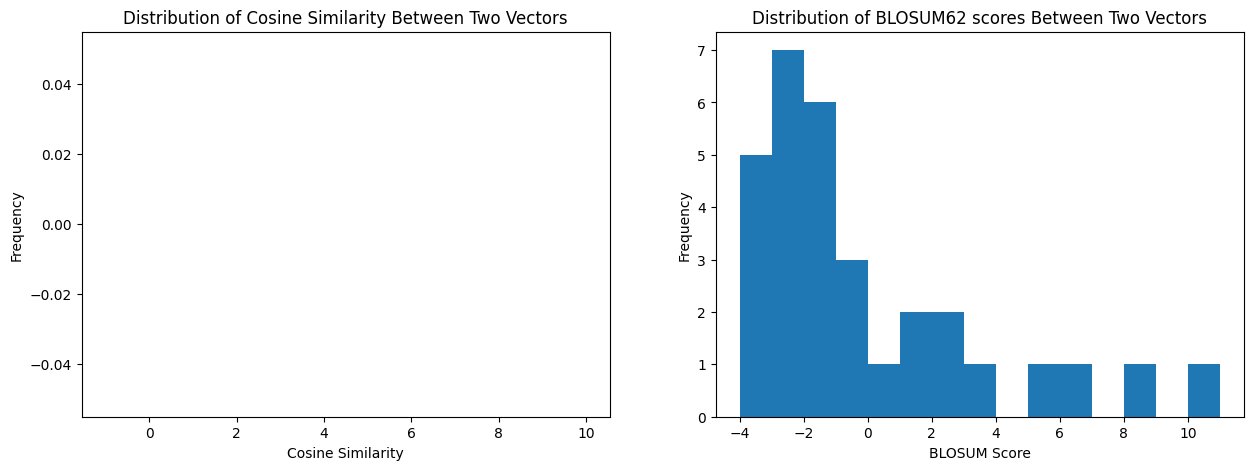

In [42]:
import matplotlib.pyplot as plt

# Compare distribution of cosine scores to distribution of BLOSUM scores
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].hist(cos_scores, bins = [i for i in range(-1, 11)])
axes[0].set_title('Distribution of Cosine Similarity Between Two Vectors')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[1].hist(blosum_scores, bins = [i for i in range(-4, 12)])
axes[1].set_title('Distribution of BLOSUM62 scores Between Two Vectors')
axes[1].set_xlabel('BLOSUM Score')
axes[1].set_ylabel('Frequency')